# LayerNorm

- LLM 数据特点
- LayerNorm 计算
- LayerNorm 可视化
- LayerNorm 训练数据分布变化
- LayerNorm 反向计算

In [18]:
import torch
import torch.nn as nn
# import torch.nn as F
import math
from torch.optim import Adam
torch.manual_seed(42)

## 分布变化

1. 向量数据
2. 矩阵数据

In [6]:
vec_a = torch.randn(1, 10)
vec_b = torch.randn(1, 10)
mat_a = torch.randn(10, 10)
mat_b = torch.randn(10, 10)

print(vec_a.mean(), vec_a.var())
print(vec_b.mean(), vec_b.var())
print(mat_a.mean(), mat_a.var())
print(mat_b.mean(), mat_b.var())

tensor(0.4290) tensor(1.0318)
tensor(0.1048) tensor(0.7825)
tensor(-0.0577) tensor(1.0201)
tensor(5.2538e-05) tensor(0.9343)


In [13]:
def vec_norm(x):
    x_norm = (x-x.mean()) / torch.sqrt(x.var())
    print(x_norm.mean(), x_norm.var())
    return x_norm

vec_a_norm = vec_norm(vec_a)
vec_b_norm = vec_norm(vec_b)

tensor(-5.9605e-09) tensor(1.)
tensor(-2.3842e-08) tensor(1.0000)


In [22]:
# 对于向量数据，加法或乘法通常都会改变分布

print('without norm')
vec_a_add_b = vec_a + vec_b
print(vec_a_add_b.mean(), vec_a_add_b.var())

vec_a_mul_b = vec_a * vec_b
print(vec_a_mul_b.mean(), vec_a_mul_b.var())

print('with norm')
vec_a_add_b = vec_a_norm + vec_b_norm
print(vec_a_add_b.mean(), vec_a_add_b.var())

vec_a_mul_b = vec_a_norm * vec_b_norm
print(vec_a_mul_b.mean(), vec_a_mul_b.var())

without norm
tensor(0.5338) tensor(3.1416)
tensor(0.6422) tensor(1.9938)
with norm
tensor(0.) tensor(3.4770)
tensor(0.6647) tensor(1.6379)


由于文本数据中， token-wise 的 embedding 或 feature 都是向量形式存在，那么序列模型的 norm 发生在特征维度上。

## 为什么要用 layernorm？

1. 经过 ReLU 激活函数，数据均值非零
2. 常规 batch normalization 不适于 序列数据，序列数据存在变长特性。 快速理解 BN 的 gamma和beta参数为 `[WxH]`, 对应于语言模型 `[bs,seq_len]`, 此时当遇到 seq_len是变长情况，则 BN 难适应。

# LayerNorm pytorch实现

layernorm 公式为：

\begin{align}
    \mu_i &= \frac{1}{d}\sum_{j=1}^d x_{ij} \\
    \sigma_i^2 &= \frac{1}{d}\sum_{j=1}^d (x_{ij} - \mu_i)^2 \\
    \hat{x}_i &= \frac{x_i-\mu_i}{\sqrt{\sigma_i^2+\epsilon}}  \\
    \tilde{x}_{ij} &= \gamma_j \hat{x}_{ij} + \beta_j
\end{align}

其中, 数据$x,\hat{x},\tilde{x}\in\mathbb{R}^{N \times d}$维度不变,  $\mu,\sigma,\gamma, \hat{x} \in\mathbb{R}^{d}$。 

对于输入数据维度为 `bs, seq_len, dim`, 那么上述公式中的 `N=bs*seq_len`, 输入数据变为 `x[bs, seq_len, dim]` -> `x[bs x seq_len, dim]`, 消除序列性。所以 Layer 所表示的是 经过该层的  **所有token** 一起按照维度进行变换。

In [2]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
        self.w = nn.Linear(d_model,2) # 2分类任务

    def forward(self, x):
        # layernorm作用在(-1) 最后一维进行归一化
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        out_mean_var = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out_mean_var + self.beta # feature level
        head = self.w(out)
        return mean, var, out_mean_var, out, head

## LayerNorm debug

In [3]:
dummy_data = torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32)
print('token level mean / var')
print(dummy_data.mean(-1, keepdim=True))
print(dummy_data.var(-1, unbiased=False, keepdim=True))

print('feature level Scaled & shift')
gamma = torch.tensor([1,2,3])
beta = torch.tensor([10,100,1000])
print(gamma)
gamma * dummy_data + beta

token level mean / var
tensor([[2.],
        [5.]])
tensor([[0.6667],
        [0.6667]])
feature level Scaled & shift
tensor([1, 2, 3])


tensor([[  11.,  104., 1009.],
        [  14.,  110., 1018.]])

In [4]:
data = torch.randn(2,3,6)
ln = LayerNorm(d_model = 6)
print(ln.gamma)
print(ln.beta)

Parameter containing:
tensor([1., 1., 1., 1., 1., 1.], requires_grad=True)
Parameter containing:
tensor([0., 0., 0., 0., 0., 0.], requires_grad=True)


## LayerNorm 输出

In [5]:
mean, var, out_mean_var, out, pred  = ln(data)

In [6]:
print('n个数据有n个mean:\n', mean)
print('n个数据有n个var:\n', var)
print('不同数据找不同的mean和var做归一化变换：\n', out_mean_var)
print('缩放+偏移:\n', out)

n个数据有n个mean:
 tensor([[[ 0.2755],
         [-0.4245],
         [ 0.0315]],

        [[-0.1054],
         [ 0.3221],
         [ 0.0120]]])
n个数据有n个var:
 tensor([[[2.1164],
         [1.1506],
         [0.7887]],

        [[0.2249],
         [1.4671],
         [1.6194]]])
不同数据找不同的mean和var做归一化变换：
 tensor([[[ 1.1351e+00,  8.3294e-01,  4.2974e-01, -1.6367e+00,  2.7693e-01,
          -1.0380e+00],
         [ 3.5563e-01, -1.1002e+00, -3.0541e-01,  1.9328e+00,  2.9889e-02,
          -9.1275e-01],
         [-8.5510e-01, -6.6542e-01, -9.0122e-01,  8.2308e-01,  1.8139e+00,
          -2.1519e-01]],

        [[-8.2663e-01,  1.1492e+00,  8.9464e-01, -6.7295e-01,  8.6689e-01,
          -1.4111e+00],
         [-2.3713e-01, -8.4796e-04,  1.0332e+00, -9.6398e-01, -1.3179e+00,
           1.4866e+00],
         [-9.7969e-01, -3.9288e-01, -1.1238e+00,  6.9485e-01,  2.9752e-02,
           1.7718e+00]]])
缩放+偏移:
 tensor([[[ 1.1351e+00,  8.3294e-01,  4.2974e-01, -1.6367e+00,  2.7693e-01,
          -1.0380e+00],
 

# LayerNorm 可视化(*)

创建100个3维的词向量，将其进行 layernorm, 其数据分布在一个平面上 3-1 = 2 维的圆上。

关于 layernorm 变换的几何特性， 可参考：

1. [On the Expressivity Role of LayerNorm in Transformers' Attention](https://arxiv.org/abs/2305.02582)
2. [Geometry and Dynamics of LayerNorm](https://arxiv.org/abs/2405.04134)

In [7]:
ln_model = LayerNorm(d_model = 3)
x_3d = torch.randn(100, 3)

# # 改变数据的均值，layernorm 后的结果有 re-centred效果
# x_3d[:,1] = torch.abs(x_3d[:,1])
# x_3d[:,2] = torch.abs(x_3d[:,2])

_,_,_, y_3d, _ = ln_model(x_3d)

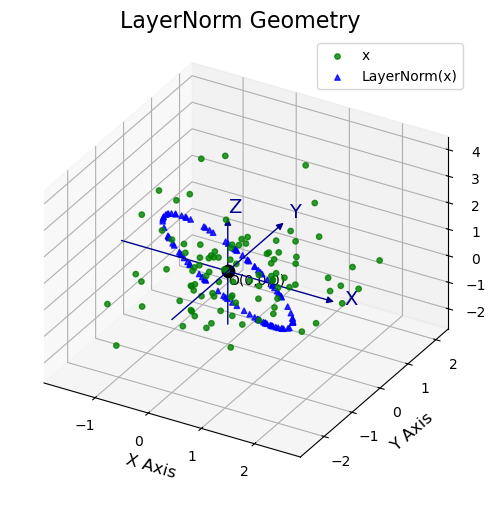

In [8]:
# 绘图代码可以skip，仅看绘制结果

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch
import numpy as np

# 自定义3D箭头类


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        return np.min(zs)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection='3d')
scatter_1 = ax.scatter(x_3d[:, 0].tolist(),
                       x_3d[:, 1].tolist(),
                       x_3d[:, 2].tolist(),
                       c='green', s=15, alpha=0.8,
                       label='x',
                       marker='o', )
scatter_2 = ax.scatter(y_3d[:, 0].tolist(),
                       y_3d[:, 1].tolist(),
                       y_3d[:, 2].tolist(),
                       c='blue', s=15, alpha=0.8,
                       marker='^',
                       label='LayerNorm(x)')
plt.legend(loc='upper right')  


# 添加坐标轴标签
ax.set_xlabel('X Axis', fontsize=12)
ax.set_ylabel('Y Axis', fontsize=12)
ax.set_zlabel('Z Axis', fontsize=12)
ax.set_title('LayerNorm Geometry', fontsize=16)

# 添加网格和调整视角
ax.grid(True, linestyle='--', alpha=0.7)
arrow_length = 2.0  # 箭头长度
arrow_props = dict(mutation_scale=10, arrowstyle='-|>',
                   color='darkblue', shrinkA=0, shrinkB=0, linewidth=1)

# X轴箭头
a = Arrow3D([-arrow_length, arrow_length], [0, 0], [0, 0], **arrow_props)
ax.add_artist(a)
ax.text(arrow_length+0.2, 0, 0, "X", fontsize=14, color='darkblue')
# Y轴箭头
b = Arrow3D([0, 0], [-arrow_length, arrow_length], [0, 0], **arrow_props)
ax.add_artist(b)
ax.text(0, arrow_length+0.2, 0, "Y", fontsize=14, color='darkblue')
# Z轴箭头
c = Arrow3D([0, 0], [0, 0], [-arrow_length, arrow_length], **arrow_props)
ax.add_artist(c)
ax.text(0, 0, arrow_length+0.2, "Z", fontsize=14, color='darkblue')

# 添加原点标记
ax.scatter(0, 0, 0, c='black', s=80, marker='o', label='Origin')
ax.text(0, 0, -0.5, "O(0,0,0)", fontsize=10, color='black')
ax.set_proj_type('ortho') 

# 显示图形
plt.tight_layout()
plt.show()

# 带LayerNorm的分类模型训练

## 训练数据和标签

增加label，观察训练过程 layernorm作用

In [9]:
data = torch.randn(2,3,6) 

data = torch.abs(data) # 将所有数据都放置到第一象限, 比如 ReLU 操作, 所有的数据的分布都是 正数

label = torch.tensor([[0,1,0], [1,1,0]], dtype=torch.long)
print(data)
print(data.shape)
label.view(-1)

tensor([[[0.6013, 0.0996, 1.2311, 0.8657, 1.4236, 0.6961],
         [0.3182, 1.2154, 0.8076, 0.8244, 1.4862, 1.4091],
         [0.3639, 0.0993, 0.3105, 0.3715, 0.1527, 0.0388]],

        [[0.2130, 0.5904, 0.8281, 0.1104, 0.3016, 1.4033],
         [1.3271, 0.9948, 0.4940, 1.1366, 0.6161, 0.2508],
         [0.8211, 0.0675, 0.9491, 0.3983, 0.6899, 1.3129]]])
torch.Size([2, 3, 6])


tensor([0, 1, 0, 1, 1, 0])

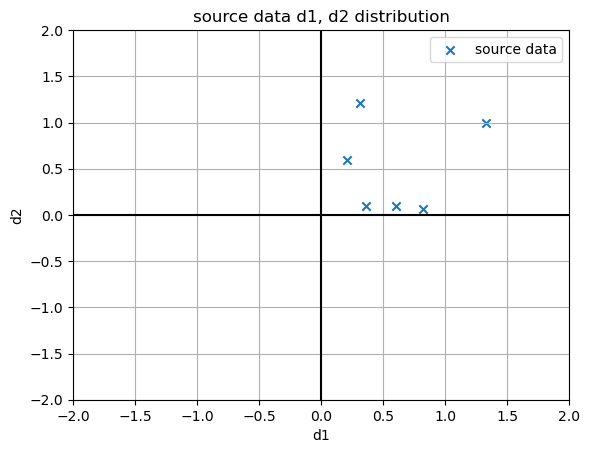

In [10]:
import matplotlib.pyplot as plt

_,_, d = data.shape
# 仅取前两维度
plt.scatter(data.view(-1,d)[:,0].tolist(), 
            data.view(-1,d)[:,1].tolist(), 
            label='source data', 
            marker='x' ) # 原始数据
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')

plt.legend()
plt.title('source data d1, d2 distribution')
plt.xlabel('d1')
plt.ylabel('d2')
plt.show()

## 训练

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=ln.parameters(),)

In [12]:
ln_outputs = []
out_mean_vars = []
for i in range(1000):
    _,_,out_mean_var,ln_out,head =ln(data)
    optimizer.zero_grad()
    loss = criterion(head.view(-1, 2), label.view(-1))
    # loss = criterion(head, label)
    loss.backward()
    optimizer.step()
    if i%100 == 0:
        print(loss.mean())
    # print(out)
    ln_outputs.append(ln_out)
    out_mean_vars.append(out_mean_var)
print('不同维度的特征有不同的缩放因子和偏移')
print('layer_norm BETA: ', ln.beta)
print('layer_norm GAMMA: ', ln.gamma)

tensor(1.1129, grad_fn=<MeanBackward0>)
tensor(0.8131, grad_fn=<MeanBackward0>)
tensor(0.6300, grad_fn=<MeanBackward0>)
tensor(0.4965, grad_fn=<MeanBackward0>)
tensor(0.3944, grad_fn=<MeanBackward0>)
tensor(0.3157, grad_fn=<MeanBackward0>)
tensor(0.2540, grad_fn=<MeanBackward0>)
tensor(0.2047, grad_fn=<MeanBackward0>)
tensor(0.1648, grad_fn=<MeanBackward0>)
tensor(0.1323, grad_fn=<MeanBackward0>)
不同维度的特征有不同的缩放因子和偏移
layer_norm BETA:  Parameter containing:
tensor([ 0.0418, -0.0360, -0.3430, -0.1400, -0.3867,  0.0299],
       requires_grad=True)
layer_norm GAMMA:  Parameter containing:
tensor([1.0033, 1.0382, 1.9962, 1.2987, 1.8576, 0.9592], requires_grad=True)


# 训练过程词特征可视化

In [13]:
xy = [ item.view(-1,d) for item in ln_outputs]
x = [ tmp[:,0].tolist() for tmp in xy]
y = [ tmp[:,1].tolist() for tmp in xy]

MV_xy = [ item.view(-1,d) for item in out_mean_vars]
MV_x = [ tmp[:,0].tolist() for tmp in MV_xy]
MV_y = [ tmp[:,1].tolist() for tmp in MV_xy]

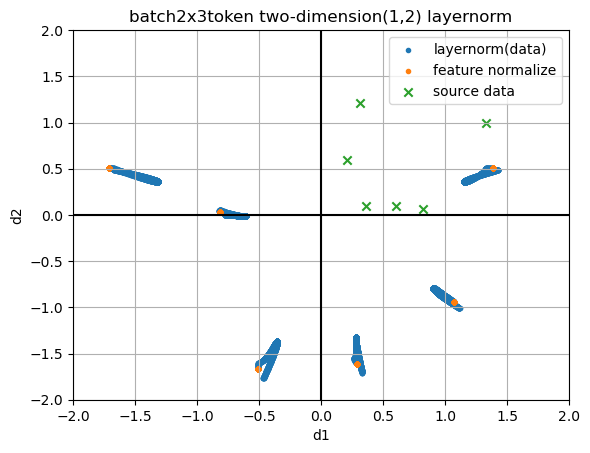

In [14]:
import matplotlib.pyplot as plt

# 仅取前两维度
plt.scatter(x, y, label='layernorm(data)', marker='.') #  laynernorm后的数据
plt.scatter(MV_x, MV_y, label='feature normalize', marker='.') #  token特征归一化的数据
plt.scatter(data.view(-1,d)[:,0].tolist(), 
            data.view(-1,d)[:,1].tolist(), 
            label='source data', 
            marker='x' ) # 原始数据
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')

plt.legend()

plt.title('batch2x3token two-dimension(1,2) layernorm')
plt.xlabel('d1')
plt.ylabel('d2')

plt.show()

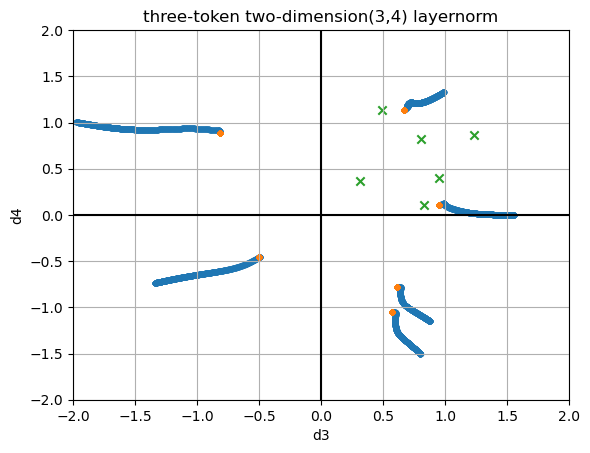

In [15]:
d1=2
d2=3

xy = [ item.view(-1,d) for item in ln_outputs]
x = [ tmp[:,d1].tolist() for tmp in xy]
y = [ tmp[:,d2].tolist() for tmp in xy]

MV_xy = [ item.view(-1,d) for item in out_mean_vars]
MV_x = [ tmp[:,d1].tolist() for tmp in MV_xy]
MV_y = [ tmp[:,d2].tolist() for tmp in MV_xy]

import matplotlib.pyplot as plt

# 仅取前两维度
plt.scatter(x, y, label='ln(data)', marker='.') #  laynernorm后的数据
plt.scatter(MV_x, MV_y, label='pre ln(data)', marker='.') #  token特征归一化的数据
plt.scatter(data.view(-1,d)[:,d1].tolist(), 
            data.view(-1,d)[:,d2].tolist(), 
            label='data', 
            marker='x' ) # 原始数据
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.grid(True, which='both')
plt.axhline(y=0, color='k', linestyle='-')
plt.axvline(x=0, color='k', linestyle='-')

plt.title('three-token two-dimension(3,4) layernorm')
plt.xlabel('d3')
plt.ylabel('d4')

plt.show()

# LayerNorm 反向(*)

In [16]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        # layernorm作用在(-1) 最后一维进行归一化
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        out_mean_var = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out_mean_var + self.beta # feature level
        return mean, var, out_mean_var, out

## 前向

In [17]:
d = 6
bs = 2
seq_len = 4 
x = torch.randn(bs, seq_len, d, requires_grad = True)
label = torch.randn(bs, seq_len, d)

model = LayerNorm(d_model = d)
mean, var, out_mean_var, y = model(x)

## 自动求导

In [18]:
loss_fn = nn.MSELoss()
loss = loss_fn(y, label)
loss.backward()

print('loss', loss.item())
print('input grad:\t', x.grad[0,0,:])
print('gamma grad:\t', model.gamma.grad)
print('beta grad:\t', model.beta.grad)

loss 1.7735947370529175
input grad:	 tensor([ 0.0214, -0.0118,  0.0041, -0.0059,  0.0167, -0.0245])
gamma grad:	 tensor([0.3215, 0.2673, 0.3550, 0.2444, 0.2368, 0.4612])
beta grad:	 tensor([-0.1874,  0.1787,  0.2313, -0.0018,  0.2808, -0.4140])


## 手撕 backward

In [19]:
with torch.no_grad(): 
    dy = 2 * (y-label) / y.numel()
    dgamma = (out_mean_var * dy).sum(dim=(0, 1))      
    dbeta = dy.sum(dim=(0, 1)) 

    x_mean = x - mean # 归一化分子
    x_std_var = torch.sqrt(var + model.eps) # 归一化分母
    
    diag_I = torch.ones(d).diag()
    I = torch.ones(d, d)
    left = diag_I - 1/d * I


    x_grad = torch.zeros_like(x)
    # 逐个 token 计算 backward
    for i in range(bs):
        for j in range(seq_len):
            d_ln = (left/x_std_var[i,j,0] - (x_mean[i,j,:].outer(x_mean[i,j,:])) / (x_std_var[i,j,0]**3 * d)) * model.gamma
            x_grad[i,j,:] = dy[i, j, :] @ d_ln

print('input grad:\t', x_grad[0,0,:])
print('gamma grad:\t', dgamma)
print('beta grad:\t', dbeta)

input grad:	 tensor([ 0.0214, -0.0118,  0.0041, -0.0059,  0.0167, -0.0245])
gamma grad:	 tensor([0.3215, 0.2673, 0.3550, 0.2444, 0.2368, 0.4612])
beta grad:	 tensor([-0.1874,  0.1787,  0.2313, -0.0018,  0.2808, -0.4140])
